# Introduction

In [2]:
import stormpy
import stormpy.core

Load the *agent stochastic maze* MDP model :

In [3]:
path = '../models/simple_mdp.prism'
prism_program = stormpy.parse_prism_program(path)

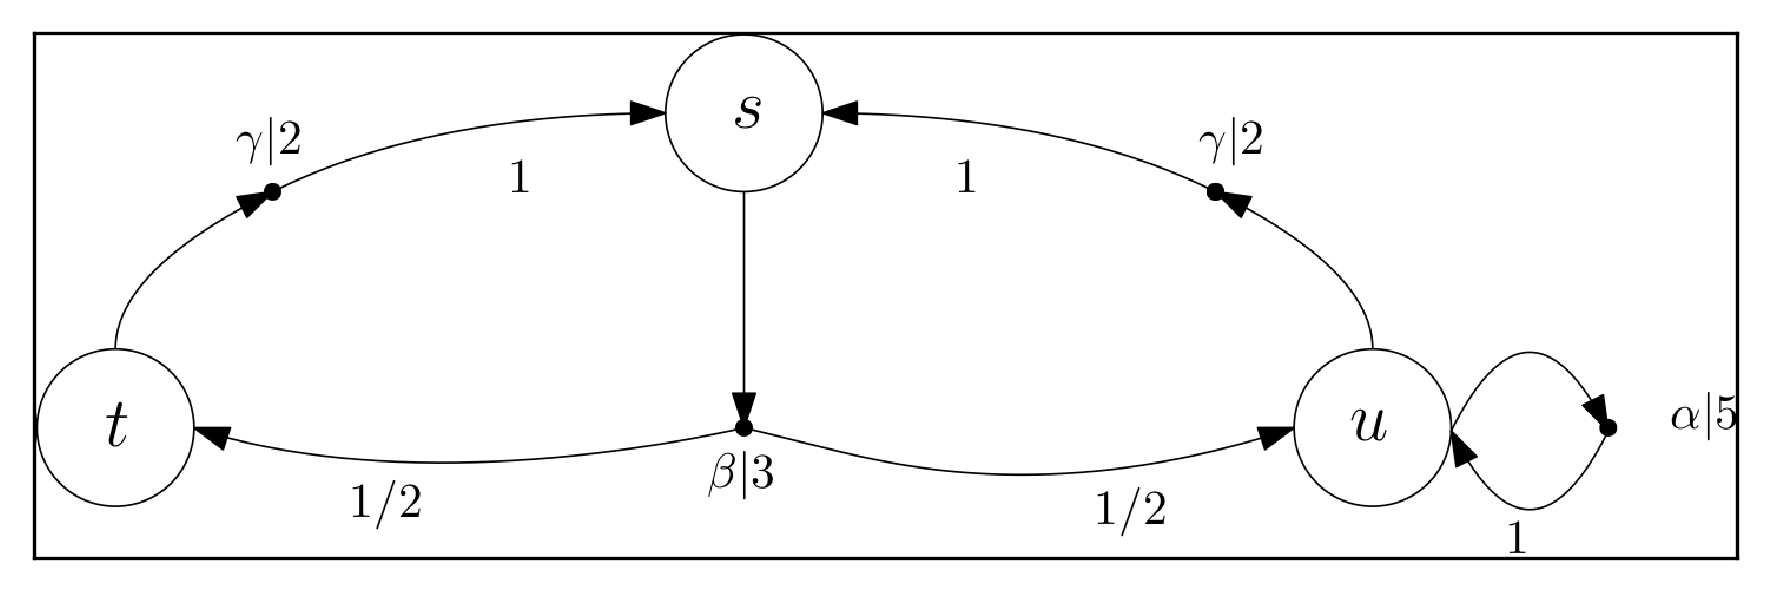

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f = plt.figure()
f.set_dpi(300)
imgplot = plt.imshow(mpimg.imread('resources/sspp1.png'))
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
f.tight_layout()
plt.show()

In [6]:
with open(path, 'r') as prism_file:
    print(prism_file.read())

mdp

module simple_mdp

s: [0..2] init 0;

[beta] s=0 -> 0.5 : (s'=1) + 0.5 : (s'=2);
[gamma] s=1 -> 1 : (s'=0);
[alpha] s=2 -> 1 : (s'=2);
[gamma] s=2 -> 1 : (s'=0);

endmodule

label "T" = s=1;
label "a" = s=0;
label "b" = s=1;

rewards "weights"
  [alpha] true : 5;
  [beta] true : 3;
  [gamma] true : 2;
endrewards



In [7]:
model = stormpy.build_model(prism_program)
print("Model Type: {}".format(model.model_type))
print("Number of states: {}".format(model.nr_states))
print("Number of transitions: {}".format(model.nr_transitions))

Model Type: ModelType.MDP
Number of states: 3
Number of transitions: 5


In [8]:
print(model.transition_matrix)

		0	1	2	
	---- group 0/2 ---- 
0	(	0	0.5	0.5		)	0
	---- group 1/2 ---- 
1	(	1	0	0		)	1
	---- group 2/2 ---- 
2	(	1	0	0		)	2
3	(	0	0	1		)	3
		0	1	2	



Solve the stochastic shortest path expectation problem :

In [11]:
# PRCTL formula
formula = 'Rmin=? [F "T"]'
properties = stormpy.parse_properties_for_prism_program(formula, prism_program)

In [12]:
model = stormpy.build_model(prism_program, properties)
print(model.labeling)
print("Labels in the model: {}".format(sorted(model.labeling.get_labels())))

3 labels
   * init -> 1 item(s)
   * deadlock -> 0 item(s)
   * T -> 1 item(s)

Labels in the model: ['T', 'deadlock', 'init']


In [13]:
result = stormpy.model_checking(model, properties[0])

In [14]:
assert result.result_for_all_states
for s, x in enumerate(result.get_values()):
    print("v[{}]={}".format(s, x))
#print(result.get_values())

v[0]=8.0
v[1]=0.0
v[2]=10.0


# Investigating the model

In [11]:
for state in model.states:
    for action in state.actions:
        descr = "[a{}:{}] s={} -> ".format(state, action, state)
        for transition in action.transitions:
            #print("From state {}, choose the action {} and go to state {} with probability {}".format(state, action, transition.column, transition.value()))
            descr += "{} : (s'={}) + ".format(transition.value(), transition.column)
        print(descr[:-2])

[a0:0] s=0 -> 0.5 : (s'=1) + 0.5 : (s'=2) 
[a1:0] s=1 -> 1.0 : (s'=0) 
[a2:0] s=2 -> 1.0 : (s'=0) 
[a2:1] s=2 -> 1.0 : (s'=2) 


In [12]:
type(model)

stormpy.storage.storage.SparseMdp

# Rewards

In [13]:
reward_model_name = list(model.reward_models.keys())[0]
reward_model_name

'weights'

In [14]:
assert(model.reward_models[reward_model_name].has_state_action_rewards)
assert not model.reward_models[reward_model_name].has_state_rewards
assert not model.reward_models[reward_model_name].has_transition_rewards

model.reward_models[reward_model_name].state_action_rewards

[3.0, 2.0, 2.0, 5.0]

# Model exportation

In [15]:
stormpy.export_to_drn(model, 'model_drn')

In [16]:
with open('model_drn', 'r') as prism_file:
    print(prism_file.read())

// Exported by storm
// Original model type: MDP
@type: MDP
@parameters

@reward_models
weights 
@nr_states
3
@model
state 0 [0] init
	action 0 [3]
		1 : 0.5
		2 : 0.5
state 1 [0] T
	action 0 [2]
		0 : 1
state 2 [0]
	action 0 [2]
		0 : 1
	action 1 [5]
		2 : 1



# Cost bounded reachability

In [32]:
with open('../models/simple_mdp_unfolding.prism', 'r') as prism_file:
    print(prism_file.read())

mdp

const int l = 8;

module classic

s: [0..2] init 0;
v: [0..l+1] init 0;

[beta] s=0 -> 0.5 : (s'=1) & (v'=min(v+3, l+1)) + 0.5 : (s'=2)&(v'=min(v+3, l+1));
[gamma] s=1 -> 1 : (s'=0) & (v'=min(v+2, l+1));
[alpha] s=2 -> 1 : (s'=2) & (v'=min(v+5, l+1));
[gamma] s=2 -> 1 : (s'=0) & (v'=min(v+2, l+1));

endmodule

label "T" = (s=1 & v<=8);

rewards "weights"
  [alpha] true : 5;
  [beta] true : 3;
  [gamma] true : 2;
endrewards



In [34]:
# PRCTL formula
path = '../models/simple_mdp.prism'
prism_program = stormpy.parse_prism_program('../models/simple_mdp_unfolding.prism')
formula = 'Pmax=? [F "T"]'
properties = stormpy.parse_properties_for_prism_program(formula, prism_program)
model = stormpy.build_model(prism_program, properties)
result = stormpy.model_checking(model, properties[0])
assert result.result_for_all_states
for s, x in enumerate(result.get_values()):
    print("v[{}]={}".format(s, x))

v[0]=0.75
v[1]=1.0
v[2]=0.5
v[3]=0.5
v[4]=0.0
v[5]=1.0
v[6]=0.0
v[7]=0.0
v[8]=0.0


In [17]:
print(model.labeling)
print("Model Type: {}".format(model.model_type))
print("Number of states: {}".format(model.nr_states))
print("Number of transitions: {}".format(model.nr_transitions))
print("Initial states : {}".format(model.initial_states))

3 labels
   * init -> 1 item(s)
   * deadlock -> 0 item(s)
   * T -> 2 item(s)

Model Type: ModelType.MDP
Number of states: 9
Number of transitions: 15
Initial states : [0]


In [18]:
for state in model.states:
    for action in state.actions:
        descr = "[a{}:{}] s={} -> ".format(state, action, state)
        for transition in action.transitions:
            #print("From state {}, choose the action {} and go to state {} with probability {}".format(state, action, transition.column, transition.value()))
            descr += "{} : (s'={}) + ".format(transition.value(), transition.column)
        print(descr[:-2])

[a0:0] s=0 -> 0.5 : (s'=1) + 0.5 : (s'=2) 
[a1:0] s=1 -> 1.0 : (s'=1) 
[a2:0] s=2 -> 1.0 : (s'=3) 
[a2:1] s=2 -> 1.0 : (s'=4) 
[a3:0] s=3 -> 0.5 : (s'=4) + 0.5 : (s'=5) 
[a4:0] s=4 -> 1.0 : (s'=6) 
[a4:1] s=4 -> 1.0 : (s'=7) 
[a5:0] s=5 -> 1.0 : (s'=5) 
[a6:0] s=6 -> 0.5 : (s'=7) + 0.5 : (s'=8) 
[a7:0] s=7 -> 1.0 : (s'=6) 
[a7:1] s=7 -> 1.0 : (s'=7) 
[a8:0] s=8 -> 1.0 : (s'=6) 


In [19]:
prism_program = stormpy.parse_prism_program('../models/simple_mdp_unfolding.prism')
model = stormpy.build_model(prism_program)
reward_model_name = list(model.reward_models.keys())[0]
reward_model_name

'weights'

In [20]:
model.reward_models[reward_model_name].state_action_rewards

[3.0, 2.0, 2.0, 5.0, 3.0, 2.0, 5.0, 2.0, 3.0, 2.0, 5.0, 2.0]

*Note :* A python script is available in '../utils' to unfold a mdp to compute the cost bounded reachability from a prism file

**Cost bounded reachability** : it is also possible to compute the cost bounded reachability directly in a PRCTL request...

In [59]:
path = '../models/simple_mdp.prism'
prism_program = stormpy.parse_prism_program(path)
# PRCTL formula
formula = 'Pmax=? [F{"weights"}<=8 "T"]'
properties = stormpy.parse_properties_for_prism_program(formula, prism_program, None)
model = stormpy.build_model(prism_program)
print(model.labeling)
print("Labels in the model: {}".format(sorted(model.labeling.get_labels())))

5 labels
   * init -> 1 item(s)
   * a -> 1 item(s)
   * deadlock -> 0 item(s)
   * b -> 1 item(s)
   * T -> 1 item(s)

Labels in the model: ['T', 'a', 'b', 'deadlock', 'init']


In [60]:
model = stormpy.build_model(prism_program)
print(model.labeling)
print("Labels in the model: {}".format(sorted(model.labeling.get_labels())))

5 labels
   * init -> 1 item(s)
   * a -> 1 item(s)
   * deadlock -> 0 item(s)
   * b -> 1 item(s)
   * T -> 1 item(s)

Labels in the model: ['T', 'a', 'b', 'deadlock', 'init']


In [64]:
initial_state = model.initial_states[0]
result = stormpy.model_checking(model, properties[0])
#print("Result: {}".format(result.at(initial_state)))

RuntimeError: Checking non-trivial bounded until probabilities can only be computed for the initial states of the model.

...but it is not currently possible to get the result of this request since we cannot currently specify that properties has to be verified on the initial state of the model in stormpy 1.2.0 (last release)